**Neural Network Based on UNet Architecture**

To solve the inpainting problem I choose the UNet architecture with 3 layer and the bottlenek. A little part of the training dataset was used to validate the training.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:

ds_train, ds_info = tfds.load(
    'eurosat/rgb',
    shuffle_files=False,
    #as_supervised=True,  # Returns a tuple (img, label) instead of a dictionary {'image': img, 'label': label}
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incomplete7Y90V6/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_train = ds_train['train']

In [ ]:
ds_train = ds_train.shuffle(1000, seed = 42)

In [ ]:
train_dataset = ds_train.take(20000)
test_dataset = ds_train.skip(17000)
validation_dataset=train_dataset.skip(18000)

In [ ]:
def generator(dataset, nolines=9):
    while True:  # Start an infinite loop
        for batch in dataset:
            images = batch["image"]
            images_np = images.numpy()

            masks = np.zeros((batch_size, 64, 64))
            for i in range(batch_size):
                for j in range(nolines):
                    start_point = (np.random.randint(0, 64 - 1), 0)
                    end_point = (np.random.randint(0, 64 - 1), 63)
                    thickness = np.random.randint(2, 3)
                    masks[i] = cv2.line(masks[i], start_point, end_point, (1), thickness)

            images_np = images_np / 255.0
            masks = np.stack(((masks),) * 3, axis=-1)

            yield (images_np * masks, images_np)

# Batch the datasets
batch_size = 8
train_dataset_batched = train_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)
validation_dataset_batched = validation_dataset.batch(batch_size)

# Create generators for the batched datasets
train_generator = generator(train_dataset_batched)
test_generator = generator(test_dataset_batched)
validation_generator = generator(validation_dataset_batched)

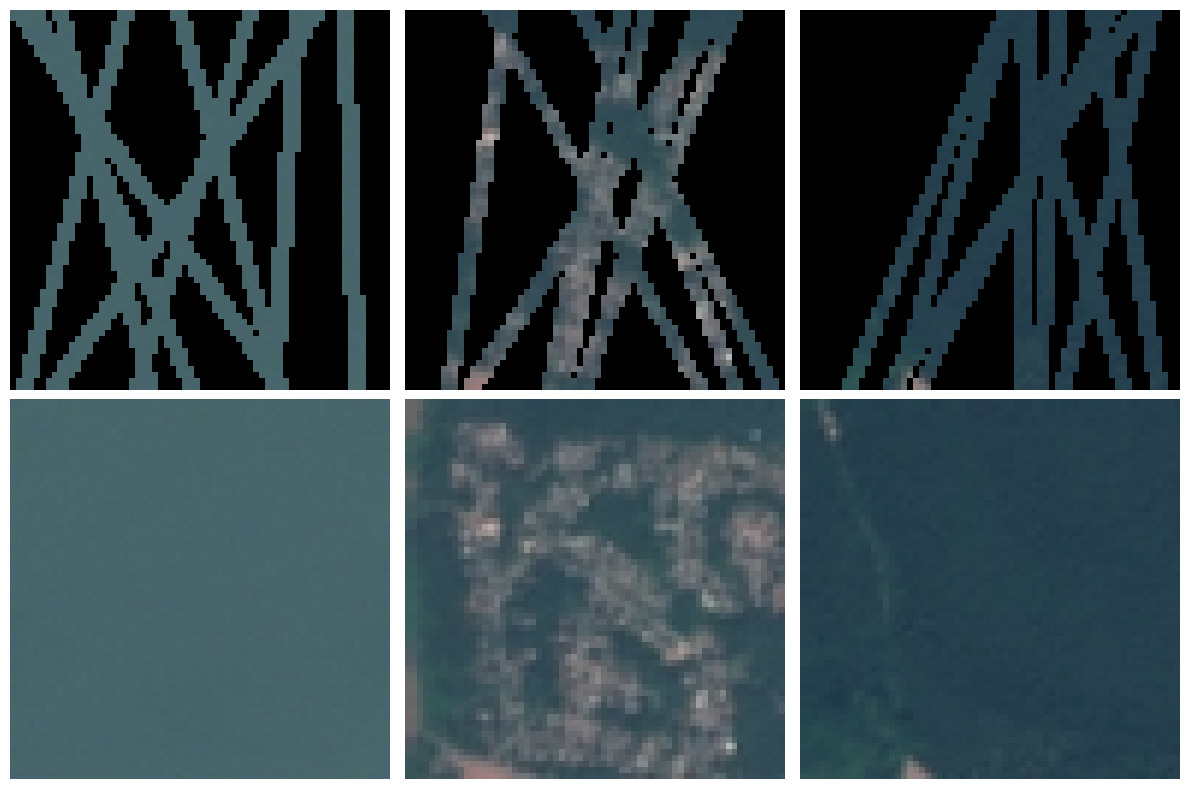

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Adjust figsize as needed
a,b = next(train_generator)
for i in range(3):
  # Plot image on each subplot
  axes[0,i].imshow(a[i])  # Use cmap='gray' if your images are grayscale
  axes[0,i].axis('off')  # Turn off axis
  axes[1,i].imshow(b[i])  # Use cmap='gray' if your images are grayscale
  axes[1,i].axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, transpose

def unet_model():
    inputs = Input(shape=(64, 64, 3))

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Additional Convolutional Layer in the Encoder
    conv2_extra = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv2_extra = Conv2D(256, 3, activation='relu', padding='same')(conv2_extra)

    # Bottleneck
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv2_extra)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=-1)
    conv4 = Conv2D.transpose(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D.transpose(128, 3, activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=-1)
    conv5 = Conv2D.transpose(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D.transpose(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    output = Conv2D.transpose(3, 3, activation='sigmoid', padding='same')(conv5)

    model = Model(inputs=inputs, outputs=output)
    return model
# Compile the model
model = unet_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

# Display model summary
model.summary()

ImportError: cannot import name 'transpose' from 'tensorflow.keras.layers' (/usr/local/lib/python3.10/dist-packages/keras/api/_v2/keras/layers/__init__.py)

In [ ]:
# Blocco 8: Addestramento e Valutazione

# Addestramento
epochs = 10
steps_per_epoch = len(train_dataset)/8  # Esempio: Imposta il numero appropriato di passi per epoca in base alle dimensioni del tuo dataset
validation_steps = len(validation_dataset)/8  # Esempio: Imposta il numero appropriato di passi per epoca in base alle dimensioni del tuo dataset
history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps)

Epoch 1/10
2500/2500 [==============================] - 58s 19ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 2/10
2500/2500 [==============================] - 46s 18ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 3/10
2500/2500 [==============================] - 46s 18ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 4/10
2500/2500 [==============================] - 47s 19ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 5/10
2500/2500 [==============================] - 47s 19ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 6/10
2500/2500 [==============================] - 47s 19ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 7/10
2500/2500 [==============================] - 47s 19ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 8/10
2500/2500 [==========================

In [ ]:
import itertools

def evaluate_model(generator, num_samples=1250, num_repeats=10):
    mse_values = []

    for repeat in range(num_repeats):
        mse_sum = 0.0
        print(f'Repeat {repeat + 1}/{num_repeats}')

        generator_iter = itertools.islice(generator, num_samples)  # Create an iterator with num_samples from the generator
        for step, (inpainted_images, original_images) in enumerate(generator_iter, 1):
            # Use the evaluate method to get the MSE directly
            mse_value = model.evaluate(inpainted_images, original_images)[0]
            mse_sum += mse_value
            #print(f'Step {step}/{num_samples} - MSE: {mse_value:.4f}')

        mean_mse_repeat = mse_sum / num_samples
        mse_values.append(mean_mse_repeat)
        print(f'Mean MSE for Repeat {repeat + 1}: {mean_mse_repeat:.4f}\n')

    return mse_values

# Calculate the mean and standard deviation of the MSE
mse_results_overall = []
for i in range(10):
    mse_results = evaluate_model(test_generator)
    mean_mse = np.mean(mse_results)
    std_dev_mse = np.std(mse_results)
    mse_results_overall.append(mean_mse)
    print(f'Overall Mean MSE for Execution {i + 1}: {mean_mse}')
    print(f'Overall Standard Deviation of MSE for Execution {i + 1}: {std_dev_mse}\n')

# Calculate mean MSE and standard deviation of MSE over the 10 executions
mean_mse_overall = np.mean(mse_results_overall)
std_dev_mse_overall = np.std(mse_results_overall)

print(f'Final Overall Mean MSE: {mean_mse_overall}')
print(f'Final Overall Standard Deviation of MSE: {std_dev_mse_overall}')

Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 33ms/step - loss: 0.0033 - mse: 0.0033
Mean MSE for Repeat 7: 0.0027

Repeat 8/10
1/1 [==============================] - 0s 40ms/step - loss: 0.0025 - mse: 0.0025
Mean MSE for Repeat 8: 0.0027

Repeat 9/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0026 - mse: 0.0026
Mean MSE for Repeat 9: 0.0027

Repeat 10/10
1/1 [==============================] - 0s 37ms/step - loss: 0.0011 - mse: 0.0011
Mean MSE for Repeat 10: 0.0027

Overall Mean MSE for Execution 10: 0.0026761863479507157
Overall Standard Deviation of MSE for Execution 10: 1.1206801420270191e-05

Final Overall Mean MSE: 0.0026769256439455784
Final Overall Standard Deviation of MSE: 3.4611871179642815e-06


1/1 [==============================] - 0s 168ms/step


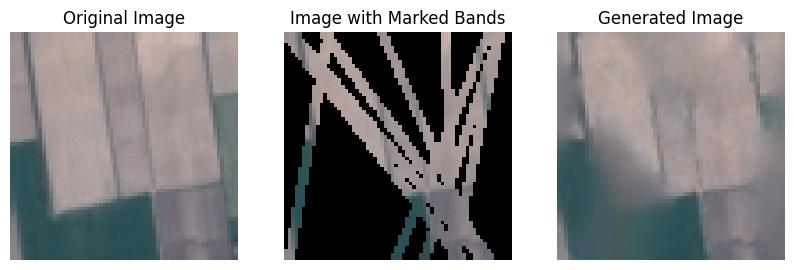

1/1 [==============================] - 0s 19ms/step


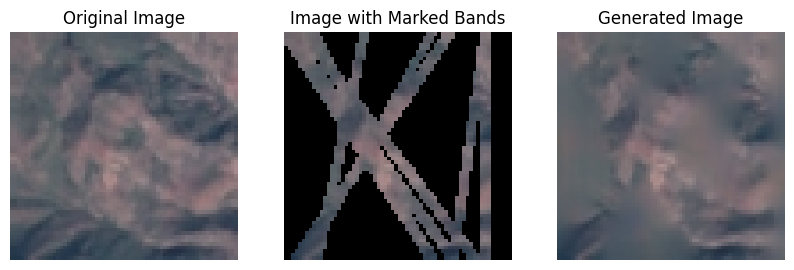

1/1 [==============================] - 0s 20ms/step


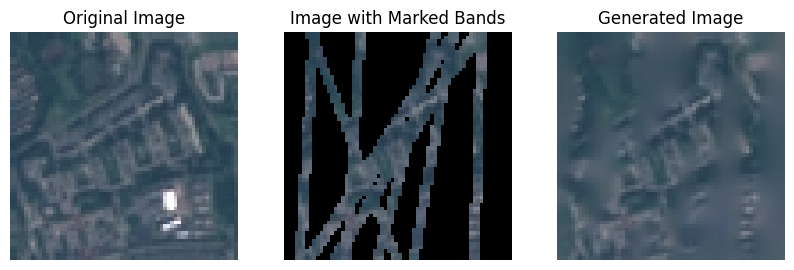

In [ ]:
# Blocco 8: Genera e visualizza alcune immagini con il modello di inpainting
num_examples = 3

for _ in range(num_examples):
    test_images, original_images = next(test_generator)  # Usa il generatore esistente

    # Esegui la previsione con il modello UNet
    generated_images = model.predict(test_images)

    # Visualizza le immagini
    plt.figure(figsize=(10, 5))

    # Immagine originale
    plt.subplot(1, 3, 1)
    plt.imshow(original_images[0])
    plt.title('Original Image')
    plt.axis('off')

    # Immagine con bande mark (stessa dell'originale se già markata)
    plt.subplot(1, 3, 2)
    plt.imshow(test_images[0])
    plt.title('Image with Marked Bands')
    plt.axis('off')

    # Immagine generata
    plt.subplot(1, 3, 3)
    plt.imshow(generated_images[0])
    plt.title('Generated Image')
    plt.axis('off')

    plt.show()